# siameseEfficientFaceNet

In [1]:
import os, io, copy
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
MODEL_NAME = 'siameseEfficientFaceNet - run18'

IMG_SHAPE = (224, 224, 3)
IMG_SIZE = IMG_SHAPE[:-1]

TEST_SIZE = 0.1
VAL_SIZE = 0.1

IMG_PER_CLASS = 4
CLASS_PER_BATCH = 15
NEG_IMG_PER_BATCH = 4
BATCH_SIZE = (IMG_PER_CLASS * CLASS_PER_BATCH) + NEG_IMG_PER_BATCH

EPOCHS = 100
INITIAL_LR = 1e-6

MARGIN = 0.2
DIST_METRIC = 'angular'

BASE_PATH = 'C:/Users/ngwei/Desktop/ITI110 Deep Learning Project'
DATASET_PATH = os.path.join(BASE_PATH, 'data', 'main')
MODEL_RUN_PATH = os.path.join(BASE_PATH, 'models', MODEL_NAME)
TB_LOG_PATH = os.path.join(BASE_PATH, 'tb_logs', MODEL_NAME)

if not os.path.isdir(MODEL_RUN_PATH):
    os.mkdir(MODEL_RUN_PATH)

In [3]:
def plot_history(history, save_path=''):
    
    plt.style.use("ggplot")
    plt.figure(figsize=(20,6))
    
    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    
    # summarize history for triplet accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['triplet_acc'], label="train")
    plt.plot(history.history['val_triplet_acc'], label="val")
    plt.title("Model Triplet Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper left')
    
    if save_path:
        plt.savefig(save_path)

In [4]:
def load_data(path=DATASET_PATH, test_size=TEST_SIZE, val_size=VAL_SIZE):
    
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    folders = glob(path+'/*')
    
    # to ensure similar distribution of number of images per class
    def get_folder_size_bins(folders):
        folders_size = [len(os.listdir(folder)) for folder in folders]
        qcut_list = list(pd.qcut(folders_size, 10, duplicates='drop'))
        return qcut_list
    
    test_qualified_folders = [folder for folder in folders if len(os.listdir(folder)) >= 2]
    folders_size_bins = get_folder_size_bins(test_qualified_folders)
    train_folders, test_folders = train_test_split(test_qualified_folders, stratify=folders_size_bins,
                                                   test_size=test_size, random_state=1234)
    
    train_val_qualified_folders = [folder for folder in train_folders if len(os.listdir(folder)) >= IMG_PER_CLASS]
    folders_size_bins = get_folder_size_bins(train_val_qualified_folders)
    train_folders, val_folders = train_test_split(train_val_qualified_folders, stratify=folders_size_bins,
                                                  test_size=val_size, random_state=1234)
    
    label, lbl2name = 0, dict()
    for folder in train_folders:
        files = glob(folder+'/*')
        X_train.extend(files)
        y_train.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in val_folders:
        files = glob(folder+'/*')
        X_val.extend(files)
        y_val.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in test_folders:
        files = glob(folder+'/*')
        X_test.extend(files)
        y_test.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    print('Train:')
    print('\t Number of Classes:', len(train_folders))
    print('\t Number of Images: ', len(y_train), '\n')
    print('Val:')
    print('\t Number of Classes:', len(val_folders))
    print('\t Number of Images: ', len(y_val), '\n')
    print('Test:')
    print('\t Number of Classes:', len(test_folders))
    print('\t Number of Images: ', len(y_test), '\n')
    print('-'*50)
    print('Total:')
    print('\t Number of Classes:', len(train_folders)+len(val_folders)+len(test_folders))
    print('\t Number of Images: ', len(y_train)+len(y_val)+len(y_test))
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), lbl2name


(X_train_paths, y_train_labels), (X_val_paths, y_val_labels), (X_test_paths, y_test_labels), lbl2name = load_data()

Train:
	 Number of Classes: 572
	 Number of Images:  19477 

Val:
	 Number of Classes: 64
	 Number of Images:  2227 

Test:
	 Number of Classes: 178
	 Number of Images:  2742 

--------------------------------------------------
Total:
	 Number of Classes: 814
	 Number of Images:  24446


In [5]:
def image_preprocessing(path):
    image = Image.open(path).resize(IMG_SIZE)
    image = np.asarray(image).astype("float32")
    image = preprocess_input(image, data_format='channels_last')
    return image

def get_images_from_paths(img_paths, image_preprocessing_fn=image_preprocessing):
    images = [image_preprocessing_fn(path) for path in img_paths]
    return np.array(images, dtype='float32')

def image_facenet_preprocessing(path):
    image = Image.open(path).resize((160, 160))
    image = np.asarray(image).astype("float32")
    image = (image * 2/255) - 1
    return image

In [6]:
def generate_data(val=False):
    img_paths, img_labels = (copy.deepcopy(X_val_paths), copy.deepcopy(y_val_labels)) if val else \
                            (copy.deepcopy(X_train_paths), copy.deepcopy(y_train_labels))
    unique_img_labels = list(set(img_labels))

    def add_label(label, size, batch_paths, batch_labels):
        candidates_paths = [img_path for img_path, img_label in zip(img_paths, img_labels) if img_label==label]
        selected_paths = np.random.choice(candidates_paths, size=size, replace=False)
        batch_paths.extend(list(selected_paths))
        batch_labels.extend([label] * len(selected_paths))
        assert len(batch_paths) == len(batch_labels)
        return batch_paths, batch_labels
    
    while True:
        batch_paths, batch_labels = [], []
        
        selected_labels = np.random.choice(unique_img_labels, size=CLASS_PER_BATCH, replace=False)
        for label in selected_labels:
            batch_paths, batch_labels = add_label(label, IMG_PER_CLASS, batch_paths, batch_labels)
        
        candidates_neg_labels = [label for label in unique_img_labels if label not in selected_labels]
        selected_neg_labels = np.random.choice(candidates_neg_labels, size=NEG_IMG_PER_BATCH, replace=False)
        for neg_label in selected_neg_labels:
            batch_paths, batch_labels = add_label(neg_label, 1, batch_paths, batch_labels)
        
        assert len(batch_paths) == len(batch_labels) == BATCH_SIZE
        batch_images = get_images_from_paths(batch_paths)
        batch_labels = np.array(batch_labels).astype("float32")
        
        yield batch_images, batch_labels

        
train_generator = generate_data()
val_generator = generate_data(val=True)

In [7]:
def build_EfficientFaceNet(pretrained_path=''):
    
    Inp = tf.keras.layers.Input(IMG_SHAPE, name='input')
    base_model = EfficientNetB0(include_top=False, input_tensor=Inp, drop_connect_rate=0.5)
    
    x = base_model.output
    x = tf.keras.layers.Dropout(0.5, name='dropout1')(x)
    x = tf.keras.layers.DepthwiseConv2D((7,7), name='glb_depth_conv')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout2')(x)
    x = tf.keras.layers.Dense(128, name='non_norm_emb')(x)
    Out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='norm_emb')(x)
    
    EfficientFaceNet = tf.keras.models.Model(inputs=Inp,
                                             outputs=Out,
                                             name='EfficientFaceNet')
    if pretrained_path:
        EfficientFaceNet.load_weights(pretrained_path)
        
    return EfficientFaceNet

In [8]:
def get_report(model, image_preprocessing_fn, paths, labels):
    
    images = get_images_from_paths(paths, image_preprocessing_fn=image_preprocessing_fn)
    embeddings = model.predict(images)

    registered_embeddings, registered_labels = [], []
    webcam_embeddings, webcam_actual_labels = [], []
    col2label = dict()

    for embedding, label in zip(embeddings, labels):
        if label not in registered_labels:
            registered_embeddings.append(embedding)
            registered_labels.append(label)
            col2label[len(col2label)] = label
        else:
            webcam_embeddings.append(embedding)
            webcam_actual_labels.append(label)
    
    cosine_similarities = np.matmul(webcam_embeddings, np.transpose(registered_embeddings))

    webcam_predicted_col = np.argmax(cosine_similarities, axis=1)
    webcam_predicted_labels = list(map(lambda col: col2label[col], webcam_predicted_col))

    webcam_actual_names = list(map(lambda lbl: lbl2name[lbl], webcam_actual_labels))
    webcam_predicted_names = list(map(lambda lbl: lbl2name[lbl], webcam_predicted_labels))
    
    print(classification_report(webcam_actual_names, webcam_predicted_names))

# Codes for Accuracy Metric

Only applies to custom metric. Loss from tfa is still used.

In [9]:
# Adapted from source code
# https://github.com/tensorflow/addons/blob/v0.15.0/tensorflow_addons/losses/metric_learning.py


@tf.function
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
      squared: Boolean, whether or not to square the pairwise distances.
    Returns:
      pairwise_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    pairwise_distances_squared = (
        tf.math.add(
            tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
            tf.math.reduce_sum(
                tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
            ),
        )
        - 2.0 * tf.matmul(feature, tf.transpose(feature))
    )

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances


@tf.function
def angular_distance(feature):
    """Computes the angular distance matrix.
    output[i, j] = 1 - cosine_similarity(feature[i, :], feature[j, :])
    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
    Returns:
      angular_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    # normalize input
    feature = tf.math.l2_normalize(feature, axis=1)

    # create adjaceny matrix of cosine similarity
    angular_distances = 1 - tf.matmul(feature, feature, transpose_b=True)

    # ensure all distances > 1e-16
    angular_distances = tf.maximum(angular_distances, 0.0)

    return angular_distances

In [10]:
# Adapted from source code
# https://github.com/tensorflow/addons/blob/v0.15.0/tensorflow_addons/losses/triplet.py


@tf.function
def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.
    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.
    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums


@tf.function
def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.
    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.
    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


@tf.function
def triplet_acc(y_true, y_pred, margin=MARGIN, distance_metric=DIST_METRIC):
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, dtype=tf.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = angular_distance(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)
    
    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )
    
    
    # Idea from
    # https://stackoverflow.com/questions/62952189/custom-accuracy-function-for-triplet-loss-training
    # Note that the positive_triplet is not the num_positives
    # num_positives here refers to number of anchor-positive pairs as described in FaceNet paper
    # positive_triplet on stackoverflow refers to number of triplets where loss > 0
    num_hard_semihard = tf.math.reduce_sum(
        tf.cast(
            tf.math.greater(tf.math.multiply(loss_mat, mask_positives), 0.0),
            dtype=tf.dtypes.float32
        )
    )
    num_valids = num_positives
    
    return 1 - (num_hard_semihard / num_valids)

# Training

In [11]:
EfficientFaceNet = build_EfficientFaceNet(
    os.path.join(BASE_PATH, 'models', 'distilEfficientFaceNet - run6', 'savedweights_distilEfficientFaceNet - run6')
)

trainable = False
for layer in EfficientFaceNet.layers:
    layer.trainable = False if isinstance(layer, tf.keras.layers.BatchNormalization) else trainable
    if layer.name == 'block4c_add': # Set layers **AFTER** to trainable=True
        trainable = True

EfficientFaceNet.summary()

Model: "EfficientFaceNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________

In [12]:
callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=f'{TB_LOG_PATH}'),
    tf.keras.callbacks.CSVLogger(os.path.join(MODEL_RUN_PATH, 'training.log')),
]

In [13]:
EfficientFaceNet.compile(
    optimizer = tf.keras.optimizers.Adam(INITIAL_LR), # tf.keras.optimizers.Adagrad(INITIAL_LR),
    loss = tfa.losses.TripletSemiHardLoss(distance_metric=DIST_METRIC, margin=MARGIN),
    metrics = [triplet_acc],
)

In [14]:
EfficientFaceNet.fit(
    train_generator,
    validation_data = val_generator,
    epochs = EPOCHS,
    steps_per_epoch = np.ceil(len(X_train_paths) / BATCH_SIZE),
    validation_steps = np.ceil(len(X_val_paths) / BATCH_SIZE),
    callbacks = callbacks,
    verbose = 1,
)

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
305/305 [==============================] - 105s 319ms/step - loss: 0.0206 - triplet_acc: 0.8060 - val_loss: 0.0150 - val_triplet_acc: 0.8644
Epoch 2/100
305/305 [==============================] - 94s 310ms/step - loss: 0.0199 - triplet_acc: 0.8119 - val_loss: 0.0147 - val_triplet_acc: 0.8670
Epoch 3/100
305/305 [==============================] - 95s 313ms/step - loss: 0.0196 - triplet_acc: 0.8154 - val_loss: 0.0140 - val_triplet_acc: 0.8738
Epoch 4/100
305/305 [==============================] - 94s 310ms/step - loss: 0.0191 - triplet_acc: 0.8195 - val_loss: 0.0153 - val_triplet_acc: 0.8557
Epoch 5/100
305/305 [==============================] - 95s 312ms/step - loss: 0.0189 - triplet_acc: 0.8227 - val_loss: 0.0147 - val_triplet_acc: 0.8641
Epoch 6/100
305/305 [==============================] - 97s 319ms/step - loss: 0.0177 - triplet_acc: 0.8291 - val_loss: 0.0168 - val_triplet_acc: 0.8532
Epoch 7/100
305/305 [==============================] - 98s 321ms/step - loss: 0.0178 - 

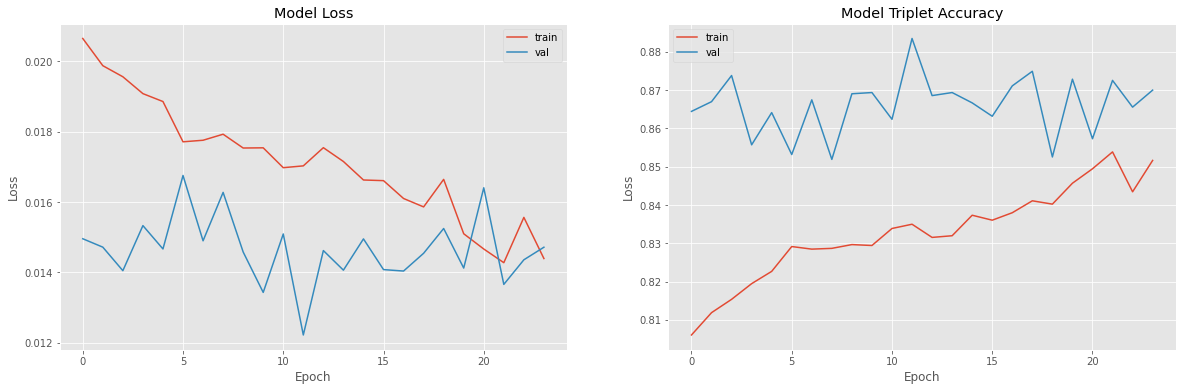

In [15]:
plot_history(EfficientFaceNet.history, os.path.join(MODEL_RUN_PATH, f'training_plot_{MODEL_NAME}'))

In [16]:
EfficientFaceNet.save_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

# Validation

In [17]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [18]:
get_report(EfficientFaceNet, image_preprocessing, X_val_paths, y_val_labels)

                         precision    recall  f1-score   support

      alastair_campbell       0.80      1.00      0.89         4
 aleksander_kwasniewski       1.00      1.00      1.00         3
           alvaro_morte       0.99      0.96      0.98       138
           amanda_bynes       0.50      0.67      0.57         3
   binyamin_ben_eliezer       0.86      1.00      0.92         6
           brad_garrett       1.00      1.00      1.00         3
          camila_mendes       0.98      0.99      0.98       161
          charles_moose       1.00      0.92      0.96        12
         choi_sung_hong       1.00      1.00      1.00         4
           clara_harris       1.00      1.00      1.00         4
            david_wells       1.00      1.00      1.00         6
            derek_jeter       0.23      1.00      0.38         3
  dominique_de_villepin       1.00      0.93      0.96        14
         edmund_stoiber       0.92      0.92      0.92        12
           eliza_taylor 

# Embedding Projection

In [19]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [20]:
# https://projector.tensorflow.org/

# Evaluate the network
np.random.seed(1234)
labels, counts = np.unique(y_val_labels, return_counts=True)
candidates_sample_labels = [lbl for lbl, cnt in zip(labels, counts) if cnt >= 10]
selected_sample_labels = np.random.choice(candidates_sample_labels, 10, replace=False)

X_sample_paths = [path for path, label in zip(X_val_paths, y_val_labels) if label in selected_sample_labels]
y_sample_labels = [label for label in y_val_labels if label in selected_sample_labels]

sample_images = get_images_from_paths(X_sample_paths)
val_results = EfficientFaceNet.predict(sample_images)

# Save test embeddings for visualization in projector
np.savetxt(os.path.join(MODEL_RUN_PATH, f'val_embedding_results_{MODEL_NAME}.tsv'), val_results, delimiter='\t')

out_m = io.open(os.path.join(MODEL_RUN_PATH, f'val_embedding_meta_{MODEL_NAME}.tsv'), 'w', encoding='utf-8')
for img, label in zip(sample_images, y_sample_labels):
    [out_m.write(str(lbl2name[label]) + "\n")]
out_m.close()

# Testing

In [21]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [22]:
get_report(EfficientFaceNet, image_preprocessing, X_test_paths, y_test_labels)

                              precision    recall  f1-score   support

         abdel_nasser_assidi       0.00      0.00      0.00         1
                    abdullah       0.43      1.00      0.60         3
            abdullatif_sener       0.33      1.00      0.50         1
abid_hamid_mahmud_al_tikriti       0.40      1.00      0.57         2
              adrian_nastase       0.50      1.00      0.67         1
                adrien_brody       0.77      0.91      0.83        11
                   al_pacino       1.00      1.00      1.00         2
                alan_mulally       0.50      1.00      0.67         1
                albert_costa       0.62      1.00      0.77         5
                   alex_sink       1.00      1.00      1.00         2
                 amanda_crew       0.97      0.97      0.97       116
               amer_al_saadi       0.60      1.00      0.75         3
                amram_mitzna       0.00      0.00      0.00         1
                and

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Compare with Facenet

In [23]:
FaceNet = tf.keras.models.load_model(os.path.join(BASE_PATH, 'models', 'FaceNet', 'facenet_model'))

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\keras\layers\core.py:1043: UserWarning: keras.layers.core.lambda_layer is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [24]:
get_report(FaceNet, image_facenet_preprocessing, X_test_paths, y_test_labels)

                              precision    recall  f1-score   support

         abdel_nasser_assidi       0.00      0.00      0.00         1
                    abdullah       0.75      1.00      0.86         3
            abdullatif_sener       0.11      1.00      0.20         1
abid_hamid_mahmud_al_tikriti       1.00      1.00      1.00         2
              adrian_nastase       1.00      1.00      1.00         1
                adrien_brody       1.00      0.91      0.95        11
                   al_pacino       0.33      1.00      0.50         2
                alan_mulally       0.50      1.00      0.67         1
                albert_costa       1.00      1.00      1.00         5
                   alex_sink       0.50      1.00      0.67         2
                 amanda_crew       0.99      0.97      0.98       116
               amer_al_saadi       0.75      1.00      0.86         3
                amram_mitzna       0.00      0.00      0.00         1
                and

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# References

<ol>

<li>FaceNet Paper</li>
<a href="https://arxiv.org/pdf/1503.03832.pdf">https://arxiv.org/pdf/1503.03832.pdf</a>

<li>TFA Triplet Loss Documentations</li>
<a href="https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss">
    https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss
</a>
<a href="https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletHardLoss">
    https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletHardLoss
</a>

<li>TFA Triplet Loss Tutorial</li>
<a href="https://www.tensorflow.org/addons/tutorials/losses_triplet">
    https://www.tensorflow.org/addons/tutorials/losses_triplet
</a>

<li>Online Triplet Mining Explanation</li>
<a href="https://omoindrot.github.io/triplet-loss">
    https://omoindrot.github.io/triplet-loss
</a>


<li>Pins Face Kaggle Dataset</li>
<a href="https://www.kaggle.com/hereisburak/pins-face-recognition">
    https://www.kaggle.com/hereisburak/pins-face-recognition
</a>

<li>LFW Dataset</li>
<a href="http://vis-www.cs.umass.edu/lfw/">
    http://vis-www.cs.umass.edu/lfw/
</a>
    
</ol>